## Setup

In [3]:
import reproducibility

In [4]:
# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
# from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
import pickle, os
from utils import hash2
%matplotlib inline

# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan, load_and_fix_data
from data_funcs import raws_data, synthetic_data, plot_data, check_data, rmse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import run_case, run_rnn, create_RNN_2, staircase, create_rnn_data, train_rnn, rnn_predict


## User options

In [5]:
# Change directory for data read/write
os.chdir('data')

dict_file='raws_dat.pickle' # input path of FMDA dictionaries
output_path='output.json' # RNN output file
reproducibility_file='reproducibility_dict.pickle'

In [6]:
param_sets={}
param_sets.update({0:{'id':0,   
        'purpose':'reproducibility',
        'cases':['case11'],
        'scale':0,
        'rain_do':False,
        'verbose':False,
        'timesteps':5,
        'activation':['linear','linear'],
        'centering':[0.0,0.0],
        'hidden_units':6,
        'dense_units':1,
        'dense_layers':1,
        'DeltaE':[0,-1],    # -1.0 is to correct E bias but put at the end
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain                              
        'epochs':5000,
        'verbose_fit':False,
        'verbose_weights':False,
        'note':'check 5 should give zero error'
}})

In [7]:
param_sets.update({1:{'id':1,
        'purpose':'test 1',
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['linear','linear'],
        'hidden_units':20,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[0.0,0.0],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':1000,
        'verbose_fit':False,
        'verbose_weights':False,
}})

In [8]:
param_sets.update({2:{'id':2,
        'purpose':'test 2',
        'cases':'all',
        'scale':0.8,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['tanh','tanh'],
        'hidden_units':20,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'DeltaE':[0,-1],    # bias correction
        'centering':[0.0,0.0],  # should be activation at 0
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':10000,
        'verbose_fit':False,
        'verbose_weights':False,
}})

In [9]:
param_sets.update({3:{'id':3,
        'purpose':'test 3',
        'cases':'all',
        'scale':0.8,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['sigmoid','sigmoid'],
        'hidden_units':20,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'DeltaE':[0,0],    # bias correction
        'centering':[0.5,0.5],  # should be activation at 0
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':10000,
        'verbose_fit':False,
        'verbose_weights':False,
}})

In [10]:
# read test datasets|
# case_data = from_json('rnn_orig.json')
test_dict={}
# test_dict.update(load_and_fix_data('testing_dict.pickle'))
test_dict.update(load_and_fix_data(dict_file))
print(test_dict.keys())

repro_dict={}
repro_dict.update(load_and_fix_data(reproducibility_file))
print(repro_dict.keys())

After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan

params_sets.keys()= dict_keys([0, 1, 2, 3])
{
    "0": {
        "DeltaE": [
            0,
            -1
        ],
        "T1": 0.1,
        "activation": [
            "linear",
            "linear"
        ],
        "cases": [
            "case11"
        ],
        "centering": [
            0.0,
            0.0
        ],
        "dense_layers": 1,
        "dense_units": 1,
        "epochs": 5000,
        "fm_raise_vs_rain": 2.0,
        "hidden_units": 6,
        "id": 0,
        "note": "check 5 should give zero error",
        "purpose": "reproducibility",
        "rain_do": false,
        "scale": 0,
        "synthetic": false,
        "timesteps": 5,
        "verbose": false,
        "verbose_fit": false,
        "verbose_weights": false
    },
    "1": {
        "DeltaE": [
            0,
            -1
        ],
        "T1": 0.1,
        "activation": [
            "linear",
            "linear"
        ],
        "cases": "all",
        "centering": [
            0.0

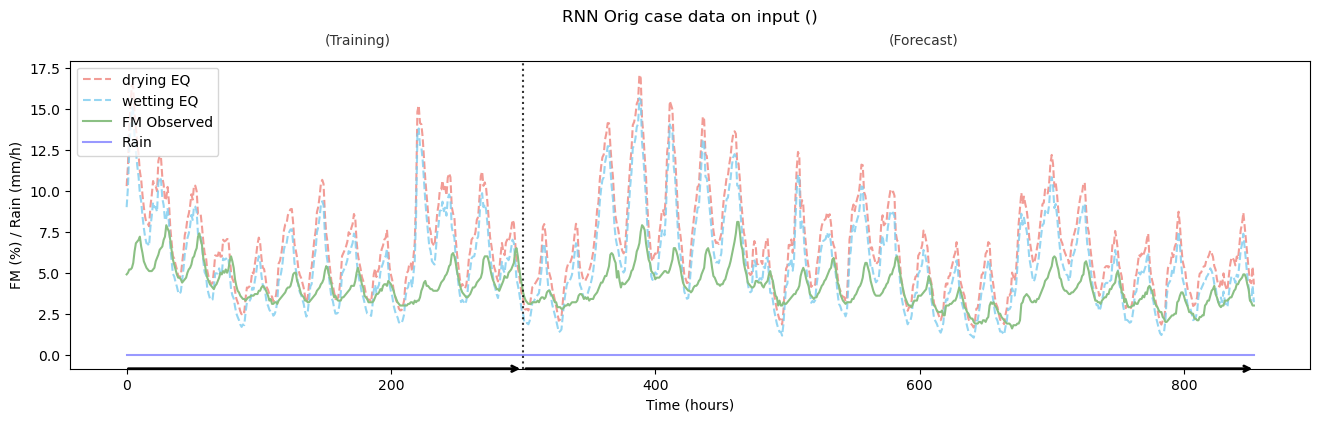

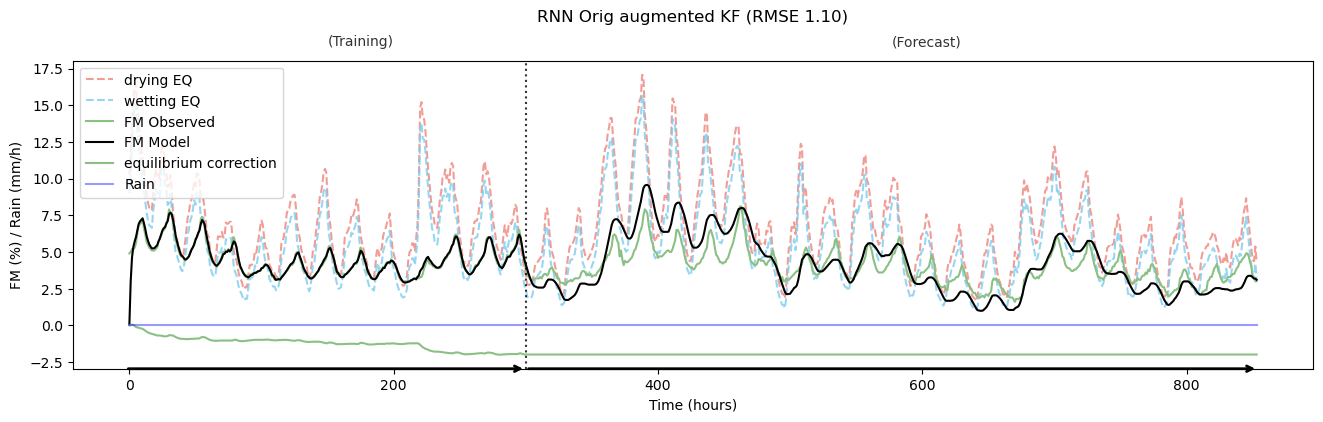

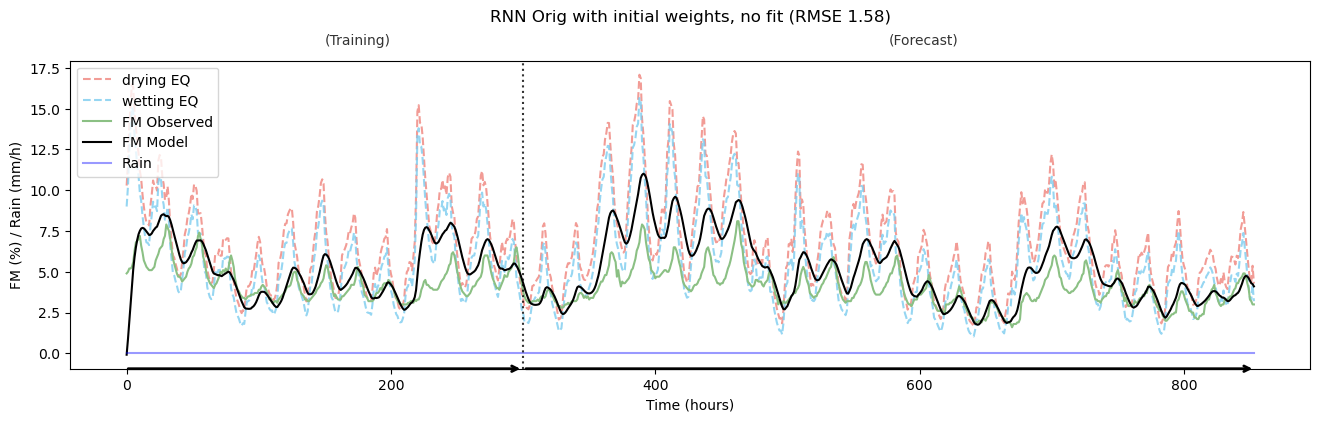

case11 Training 1 to 300 hours RMSE:   1.327
case11 Prediction 301 to 854 hours RMSE: 1.5834
resetting random seeds to 123
check 5: 5.55077327554663e+19 should be 5.55077327554663e+19 error 0.0
checkm= 3.77920889854431152  error 0.0


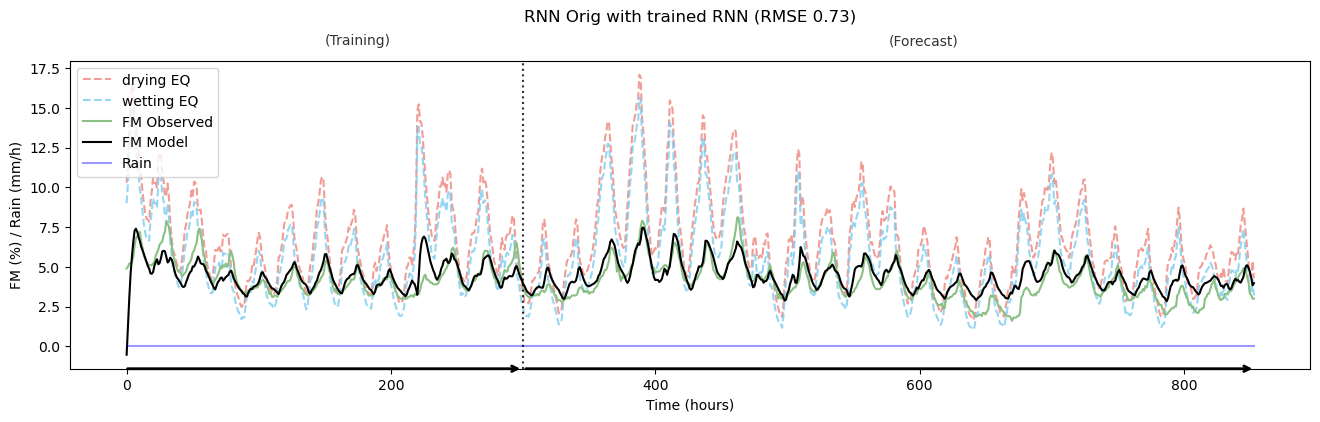

case11 Training 1 to 300 hours RMSE:   0.7998
case11 Prediction 301 to 854 hours RMSE: 0.733
*** params 0 reproducibility case summary ***
params= {'id': 0, 'purpose': 'reproducibility', 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': False, 'verbose_weights': False, 'note': 'check 5 should give zero error'}
outputs= {
    "Augmented KF": {
        "all": 0.9061249439407393,
        "predict": 1.0984268618847821,
        "train": 0.33047073142627476
    },
    "RNN initial": {
        "all": 1.4983486205665615,
        "predict": 1.58343693275214,
        "train": 1.3269545567623797
    },
    "RNN trained": {
        "all": 0.7571178921192675,
        "predict": 0.7329811098096649,
        "train": 0.7997781420018454
    }
}
writ

ValueError: cannot reshape array of size 11013 into shape (1,720,3)

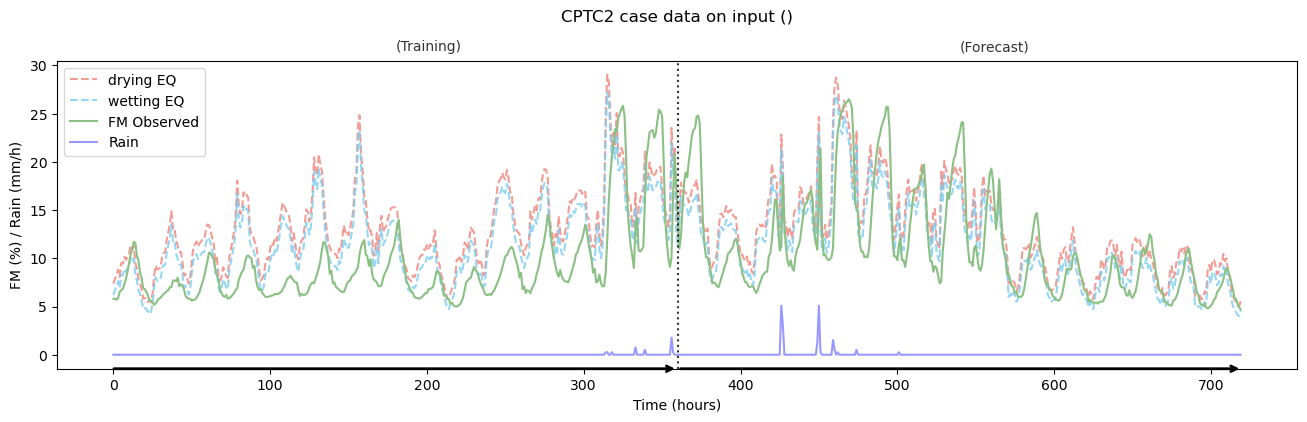

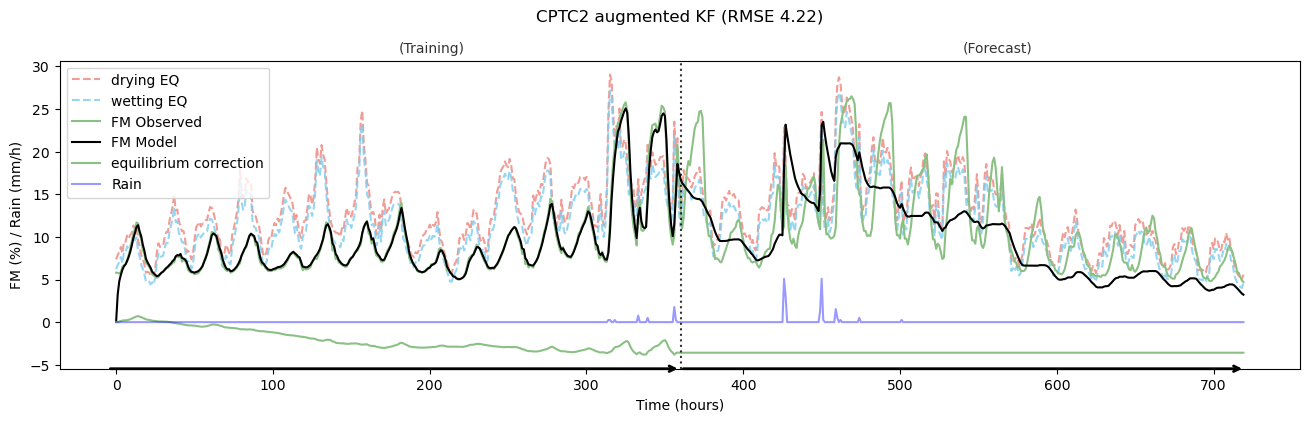

In [11]:
output={}
print('params_sets.keys()=',param_sets.keys())
print(json.dumps(param_sets,indent=4,sort_keys=True))

for i in param_sets:
#for params in param_sets:
    print('i=',i)
    params=param_sets[i]
    if i == 0:
        # Run reproducbility case
        print('Running reproducibility')
        assert param_sets[i]['purpose'] == 'reproducibility'
        output[i]={'params':params,'cases':{}}
        case = 'case11'
        case_data=repro_dict[case]
        output[i]['cases'][case]=run_case(case_data,params)
        print('*** params',i,'reproducibility case','summary ***')
        print('params=',params)
        print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
        print('writing the results to file',output_path)
        json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
    else:
        #print('params=',params)
        if params['cases'] == 'all':
            params['cases'] = list(test_dict.keys())
            print("expanding 'all' to",params['cases'])
        output[i]={'params':params,'cases':{}}
        cases = params['cases']
        print('cases=',cases)
        for case in cases:
            print('case=',case)
            # print(json.dumps(params,indent=4,sort_keys=True))
            case_data=test_dict[case]
            if not 'title' in case_data.keys():
                case_data['title']=case
            if not 'hours' in case_data.keys():
                case_data['hours']=720
                case_data['h2']=480
            if params['synthetic'] or 'Synth' not in case_data['title']: 
                output[i]['cases'][case]=run_case(case_data,params)  # add to results
                print('*** params',i,'case',case,'summary ***')
                print('params=',params)
                print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
                print('writing the results to file',output_path)
                json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
        print('cases=',cases)
print(json.dumps(output,indent=4,sort_keys=True))
   